# Particle filters

In [1]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Robot class
Code provided as course materials.

In [2]:
class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
   
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise)
        self.turn_noise    = float(new_t_noise)
        self.sense_noise   = float(new_s_noise)
    
    
    def sense(self):
        # Euclidean distance of robot to each landmark
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')       
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
     
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))


def eval(r, p):
    sum = 0.0
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

In [3]:
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

## Helper functions for visualising the results

In [4]:
# robot location plotting function
def plot_robot(world_size, locs, landmarks=None, real_loc=None, clear_axes=False):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.close()
    ax.cla()

    alpha_steps = range(len(locs) + 1)[1:]
    ind = 0
    for loc, alpha in zip(locs, alpha_steps):
    
        if clear_axes:
            alpha = 1.0
        else:
            alpha = alpha / len(locs)

        if clear_axes:
            ax.cla()
        ax.plot(loc[0], loc[1], '.', color='blue', alpha=alpha)

        if landmarks:
            for landmark in landmarks:
                ax.plot(landmark[1], landmark[0], 's', color='red')

        if real_loc:
            try:
                ax.plot(
                    real_loc[ind][0], real_loc[ind][1], 'X',
                    color='green', markersize=12, alpha=alpha)
            except IndexError:
                # if there is no newer location for the real robot,
                # plot the last known location after moving
                ax.plot(
                    real_loc[-1][0], real_loc[-1][1], 'X',
                    color='green', markersize=12, alpha=alpha)
        
        ax.axis("square")
        ax.set_xlim(0, world_size)
        ax.set_ylim(0, world_size)
        ax.set_title("Robot position")
        display(fig)
        
        clear_output(wait = True)
        plt.pause(0.5)

        ind += 1

In [5]:
def save_loc(robots):
    # save x and y locations and orientation to lists for easy plotting
    [x, y, ori] = zip(*[[r.x, r.y, r.orientation] for r in robots])
    return [list(x), list(y), list(ori)]

## Moving robot
Make a robot called myrobot that starts at
coordinates 30, 50 heading north (pi/2).
Have your robot turn clockwise by pi/2, move
15 m, and sense. Then have it turn clockwise
by pi/2 again, move 10 m, and sense again.

Your program should print out the result of
your two sense measurements.

Don't modify the code above. Please enter
your code at the bottom.

In [6]:
myrobot = robot()
myrobot.set(30.0, 50.0, pi / 2.0)

locs = []
# save initial locations
locs.append(save_loc([myrobot]))

myrobot = myrobot.move(-pi / 2.0, 15.0)
# save locations after movement
locs.append(save_loc([myrobot]))
print(myrobot.sense())

myrobot = myrobot.move(-pi / 2.0, 10.0)
# save locations after movement
locs.append(save_loc([myrobot]))
print(myrobot.sense())

[39.05124837953327, 46.09772228646444, 39.05124837953327, 46.09772228646444]
[32.01562118716424, 53.150729063673246, 47.16990566028302, 40.311288741492746]


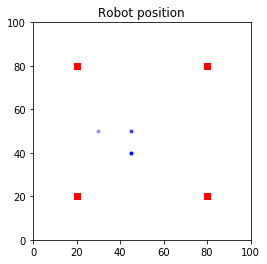

In [7]:
plot_robot(world_size, locs, landmarks)

## Add noise
Now add noise to your robot as follows:
forward_noise = 5.0, turn_noise = 0.1,
sense_noise = 5.0.

Once again, your robot starts at 30, 50,
heading north (pi/2), then turns clockwise
by pi/2, moves 15 meters, senses,
then turns clockwise by pi/2 again, moves
10 m, then senses again.

Your program should print out the result of
your two sense measurements.

Don't modify the code below. Please enter
your code at the bottom.

In [8]:
myrobot = robot()
myrobot.set_noise(new_f_noise=5.0, new_t_noise=0.1, new_s_noise=5.0)
myrobot.set(30.0, 50.0, pi / 2.0)

locs = []
# save initial locations
locs.append(save_loc([myrobot]))

myrobot = myrobot.move(-pi / 2.0, 15.0)
# save locations after movement
locs.append(save_loc([myrobot]))
print(myrobot.sense())

myrobot = myrobot.move(-pi / 2.0, 10.0)
# save locations after movement
locs.append(save_loc([myrobot]))
print(myrobot.sense())

[35.538748368917645, 44.61622099926404, 37.37329512058043, 56.816155387904175]
[25.54037886565859, 51.77275446893407, 50.81192102061718, 51.45626501728594]


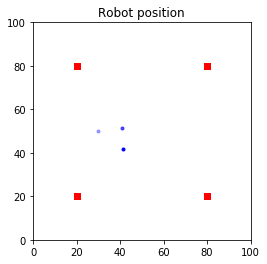

In [9]:
plot_robot(world_size, locs, landmarks)

## Robot particles
Now we want to simulate robot
motion with our particles.
Each particle should turn by 0.1
and then move by 5. 

In [10]:
N = 100
# create particles
p = [robot() for n in range(N)]
locs = []
# save initial locations
locs.append(save_loc(p))

# move all particles
p = [r.move(0.1, 5.0) for r in p]
# save new location
locs.append(save_loc(p))

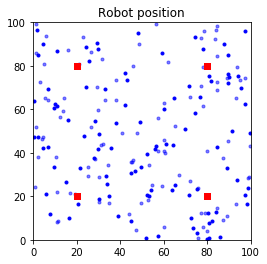

In [11]:
plot_robot(world_size, locs, landmarks)

## Particle importance weight
Compare the predicted distances to the landmarks for each particle to the measured distances to landmarks. Particles with large prediction errors get low importance weights.  

Use the provided `measurement_prob` method of the `robot` class (input: Z) to calculate how probable the measurement is. Put these in a weights vector `w`. The input `Z` is the measurements gathered from the real robot.

In [12]:
# real robot
myrobot = robot()
real_loc = []
real_loc.append(save_loc([myrobot]))
myrobot = myrobot.move(0.1, 5.0)
real_loc.append(save_loc([myrobot]))
Z = myrobot.sense()

N = 1000
p = []
# create particles
for i in range(N):
    r = robot()
    r.set_noise(0.05, 0.05, 5.0)
    p.append(r)

locs = []
# save initial locations
locs.append(save_loc(p))

# move all particles
p = [r.move(0.1, 5.0) for r in p]
# save new location
locs.append(save_loc(p))

# importance weights
w = [r.measurement_prob(Z) for r in p]

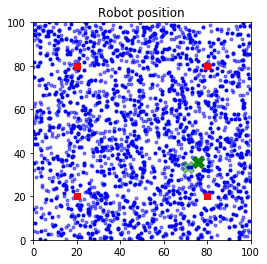

In [13]:
# all particles before and after the move (and real robot in green)
plot_robot(world_size, locs, landmarks, real_loc=real_loc)

## Resampling
Resample by normalising the importance weights and then taking a random sample from the particles, weighted by their probabilities.

### Wrong attempt 1
p3 should have 1000 particles, this gives a smaller set.

In [14]:
# normalised weights alpha
a = [weight / sum(w) for weight in w]

p3 = []
num_particles = len(p)
for particle, alpha in zip(p, a):
    if (random.random() / num_particles) < alpha:
        p3.append(particle)

### Wrong attempt 2
This does two random sampling steps, but should do one.

In [15]:
# normalised weights alpha
a = [weight / sum(w) for weight in w]

p3 = []
for ind in range(N):
    while True:
        # random index out of the original particles
        choice = random.randint(0, (N - 1))
        # choose this particle?
        if (random.random() / N) < a[choice]:
            p3.append(p[choice])
            break

### Attempt 3
Correct in Python 3 but the course autograder runs Python 2 :(

In [16]:
# normalised weights alpha
a = [weight / sum(w) for weight in w]

p3 = random.choices(population=p, weights=a, k=N)

### Attempt 4
Resampling wheel as recommended in the course

In [17]:
def resample(particles, weights, N):
    p = []
    beta = 0
    index = random.randint(0, (N - 1))
    max_w = max(weights)
    for ind in range(N):
        beta += (random.random() * 2 * max_w)
        while weights[index] < beta:
            beta -= weights[index]
            # note: index should wrap around to 0
            index = (index + 1) % N
        p.append(particles[index])
    return p

In [18]:
p = resample(p, w, N)

In [19]:
# save particle locations with particles eliminated
locs2 = []
locs2.append(save_loc(p))
# once more the current real location for plotting purposes
real_loc2 = []
real_loc2.append(save_loc([myrobot]))

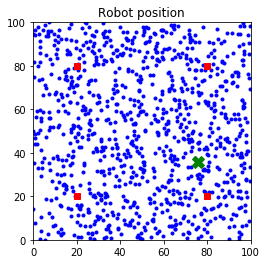

In [20]:
# original particles after the move
plot_robot(world_size, [locs[1]], landmarks, real_loc=[real_loc[1]])

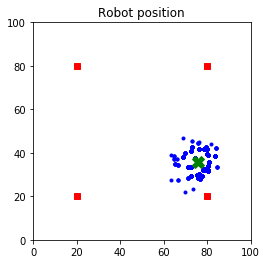

In [21]:
# particles after resampling
plot_robot(world_size, locs2, landmarks, real_loc=real_loc2)

## Run the particle filter k times

In [22]:
k = 15
N = 1000
p = []

# real robot
myrobot = robot()
real_loc = []
real_loc.append(save_loc([myrobot]))

# create particles
for i in range(N):
    r = robot()
    r.set_noise(0.05, 0.05, 5.0)
    p.append(r)

locs = []
# save initial particle locations
locs.append(save_loc(p))

# mean error
error = []

# move and resample k times
for ind in range(k):
    # move the robot
    myrobot = myrobot.move(0.1, 5.0)
    real_loc.append(save_loc([myrobot]))
    Z = myrobot.sense()
    
    # move all particles
    p = [r.move(0.1, 5.0) for r in p]
    # save new location
    # locs.append(save_loc(p))

    # importance weights
    w = [r.measurement_prob(Z) for r in p]

    # resample
    p = resample(p, w, N)

    # save resampled particles
    locs.append(save_loc(p))

    error.append(eval(myrobot, p))

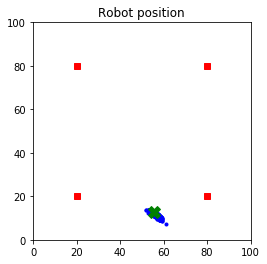

In [23]:
# particles before and after the move, with resampling
plot_robot(world_size, locs, landmarks, real_loc=real_loc, clear_axes=True)